<a href="https://colab.research.google.com/github/DianaMosquera/Diana-M/blob/master/ML1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Machine Learning Fundamentals**
© Deep Learning Indaba. Apache License 2.0.

Introducción
El objetivo de esta practica es entender la idea de clasificación (clasificación de cosas en categorías) utilizando un modelo de ML. Jugar un poco con la relación entre los parámetros de un clasificador y el límite de decisión (una línea que separa las categorías) también idea de una función de pérdida o cost function. Y luego empezar a usar Tensorflow.

Objetivos de aprendizaje:

*Comprender la idea de clasificación

*Comprender el concepto de separabilidad (lineal) de un conjunto de datos

*Comprender cuáles son los parámetros de un clasificador y cómo se relacionan con el límite de decisión

*Poder explicar brevemente qué es Tensorflow

**Importar librerías**

In [1]:
!pip install -q moviepy > /dev/null 2>&1
!pip install -q imageio > /dev/null 2>&1
!pip install -q tensorflow==2.0.0-beta0 > /dev/null 2>&1

import tensorflow as tf
import numpy as np                 # Numpy is an efficient linear algebra library.
import matplotlib.pyplot as plt    # Matplotlib is used to generate plots of data.
from matplotlib import animation, rc

from IPython import display

try:
  tf.executing_eagerly()
  print("TensorFlow executing eagerly: {}".format(tf.executing_eagerly()))
except ValueError:
  print('Already running eagerly')

TensorFlow executing eagerly: True


**Outline:** La clasificación en el aprendizaje automático implica aprender a etiquetar ejemplos en una (o más) categorías discretas. Esto difiere de otra tarea común en el aprendizaje automático llamada regresión, que implica aprender una asignación de entradas a una salida de valor continuo.

1.Comenzamos presentando un conjunto de datos de puntos rojos y azules que queremos separar.

2.Introducimos y exploramos la idea de la separabilidad lineal.

3.Definimos una pérdida como una medida de cuán bueno de un separador es una línea particular

4.Presentamos brevemente TensorFlow y mostramos cómo se puede usar para encontrar automáticamente el mínimo de una función de pérdida.

**Dear data**

Ejecuta el código en la celda a continuación y observa el diagrama resultante. Debe producir un conjunto de datos 2D simple que consta de 2 clases de puntos, las clases están representadas por los colores azul y rojo. 

Nuestra tarea es construir un clasificador binario que pueda distinguir entre los puntos rojo y azul (al rojo y al azul se les conoce como las clases de los puntos), utilizando solo las coordenadas 2-D de un punto. 

En otras palabras, queremos una función que tome como entrada un vector 2-D que represente las coordenadas de un punto y devuelva un valor de 1 o 0 que indica si el punto es rojo o azul. Aquí hemos codificado los colores rojo y azul en los números 1 y 0 (¡lo que facilita el trabajo en matemáticas y código!)

Nota: hems codificado arbitrariamente rojo como 1 y azul como 0, ¡también puedes hacerlo al revés siempre que seas coherente!

**Helper functions (run me)**

In [0]:
# this is a helper function to assist with plotting the dataset below
def plot_dataset(inputs, labels):
  # Plot the given 2D inputs and labels using Matplotlib.   
  plt.scatter(
      inputs[:, 0], inputs[:, 1], 
      c=['red' if label > 0 else 'blue' for label in labels])

  plt.axis('equal')

  plt.xlabel('x1')
  plt.ylabel('x2')

**Data**

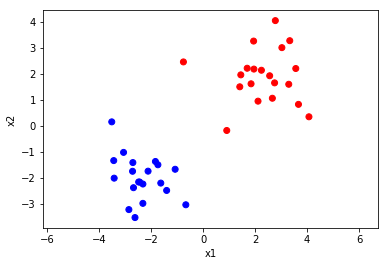

In [5]:
#@title Generate the Dataset  {run: "auto"}
# Define the centre(s) of the points
centre = 1.8    #@param {type:"slider", min:0, max:2, step:0.1}

points_in_class = 20  # How many points we want per class

# A fixed random seed is a common "trick" used in ML that allows us to recreate
# the same data when there is a random element involved. 
np.random.seed(0)  

# Generate random points in the "red" class
red_inputs = np.random.normal(loc=centre, scale=1.0, size=[points_in_class, 2])     
# Generate random points in the "blue" class
blue_inputs = np.random.normal(loc=-centre, scale=1.0, size=[points_in_class, 2])    
# Put these together
inputs = np.concatenate((red_inputs, blue_inputs), axis=0) 
    
# The class (label) is 1 for red or 0 for blue
red_labels = np.ones(points_in_class)    
blue_labels = np.zeros(points_in_class)
labels = np.concatenate((red_labels, blue_labels), axis=0)

# num_data_points is the total data set size
num_data_points = 2 * points_in_class

plot_dataset(inputs, labels)

**¿Cómo se ven los datos?**

Las entradas son vectores bidimensionales (puntos en un espacio bidimensional). Aquí están las coordenadas de 4 puntos, que hemos elegido deliberadamente para que los puntos 1 y 2 sean "rojos" y los puntos 3 y 4 sean "azules".

In [6]:
print('Input 1:\t', inputs[0])
print('Input 2:\t', inputs[1])

print('Input 3:\t', inputs[-1])
print('Input 4:\t', inputs[-2])

('Input 1:\t', array([3.56405235, 2.20015721]))
('Input 2:\t', array([2.77873798, 4.0408932 ]))
('Input 3:\t', array([-2.11155253, -1.74383466]))
('Input 4:\t', array([-2.67079715, -2.37884966]))


Las etiquetas son 0 (azul) o 1 (rojo). Aquí están las etiquetas correspondientes a los puntos anteriores:

In [7]:
print('Label 1:\t', labels[0])
print('Label 2:\t', labels[1])

print('Label 3:\t', labels[-1])
print('Label 4:\t', labels[-2])

('Label 1:\t', 1.0)
('Label 2:\t', 1.0)
('Label 3:\t', 0.0)
('Label 4:\t', 0.0)


**Separabilidad lineal**

Para un conjunto de datos bidimensional con 2 clases, podemos decir que el conjunto de datos es linealmente separable si es posible dibujar una línea (1-D) que separe los ejemplos de cada clase. 

En este caso, querríamos una línea entre los puntos rojo y azul de modo que todos los puntos rojos se encuentren en un lado de la línea y todos los puntos azules en el otro. La separabilidad lineal de un conjunto de datos D-dimensional con 2 clases significa que existe un solo plano (D-1) -dimensional (hiper-) que separa las clases (un hiperplano es una generalización de una línea recta a muchas dimensiones).


**Tarea exploratoria**

En la celda de código bajo el encabezado "Los datos", cambia el control deslizante para el valor central. Esto actualizará automáticamente el valor en el código y volverá a dibujar el gráfico.

¿A qué valor de centro el conjunto de datos se vuelve linealmente separable?

**Pregunta para discusión**

¿Puedes pensar en algunos conjuntos de datos 2D, de 2 clases, similares al anterior, que son separables (los puntos de las 2 clases no se superponen entre sí), pero no son linealmente separables? 

Dibuja algunos ejemplos en papel o complétalos con Matplotlib y mira qué pasa

**Drawing the line**
Si te acuerdas de la escuela, una ecuación $w_1x_1 + w_2x_2 = 0$ puede representar una línea en 2 dimensiones, con ejes de coordenadas $x_1$ and $x_2$,que pasa por el origen (0, 0).

También podemos escribir esto en forma de vector como: $\mathbf{w}^T\mathbf{x} = 0$, donde $\mathbf{w}^T = [w_1, w_2]$ y $\mathbf{x}^T = [x_1, x_2]$.

**Nota**: Nuestra línea de arriba pasará por el origen (0,0). Si queremos describir una línea que no pasa por el origen, necesitamos agregar un término de sesgo o bias.

Cuando una línea (o más generalmente, un hiperplano) se define de esta manera, llamamos a los **parámetros** $\mathbf{w} = (w_1, w_2)$ un **vector normal** para la línea. El vector normal es ortogonal (perpendicular) a la línea. Queremos construir una línea que separe los puntos rojo y azul, lo que llamaremos un **límite de decisión**. El nombre "límite de decisión" proviene del hecho de que la línea describe el límite en el espacio de entrada donde la salida (decisión) del modelo cambia de una clase a otra.

En la siguiente celda, trazamos nuestro conjunto de datos junto con un vector normal $\mathbf{w}$ y un límite de decisión. Puede ajustar los valores de  $w_1$ y  $w_2$ utilizando los controles deslizantes de la derecha. Observa el efecto que tienen los valores en el vector normal dibujado en rojo y el límite de decisión en negro. Ajusta los valores para que la línea negra separe los puntos azul y rojo (es decir, puntos rojos en un lado y azules en el otro). 

Tu línea también debe tener el vector normal apuntando en la dirección de los puntos rojos. La razón por la cual la dirección es significativa es que queremos clasificar eventualmente los puntos en un lado de la línea (límite de decisión) como rojos y el otro como azules.

¿Es posible encontrar una línea a través del origen que separe perfectamente los puntos?

**Nota:** Cada una de nuestras entradas es un vector 2-D, compuesto por dos valores de coordenadas. Nos referimos a estos 2 ejes de coordenadas como $x_1$ y $x_2$. Por ejemplo, si tenemos una entrada  $(1, 2)$, entonces diríamos$x_1 = 1$ y $x_2 = 2$ para ese punto.

/usr/local/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


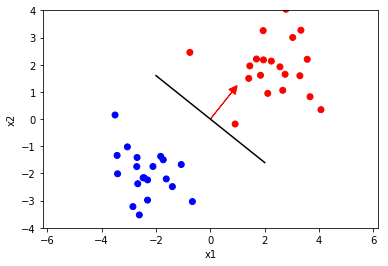

In [8]:
#@title Effect of parameters {run: "auto"}

# Define the parameters
w1 = 0.8 #@param { type: "slider", min: -5, max: 5, step: 0.1 }
w2 = 1 #@param { type: "slider", min: -5, max: 5, step: 0.1 }

plot_dataset(inputs, labels)

# Add the weight vector to the plot. We plot it in red, as it has to "point"
# in the direction of the red points.
ax = plt.axes()
ax.arrow(0, 0, w1, w2, head_width=0.3, head_length=0.3, fc='r', ec='r')

# Plot part of the decision boundary in black. It is orthogonal to the weight
# vector.
t = 2 # this is how long the line should be
plt.plot([-t * w2, t * w2], [t * w1, -t * w1], 'k-')

plt.xlim([-4, 4])
plt.ylim([-4, 4])

plt.show()

**Clasificación**

Dado un vector normal $w$, podemos evaluar a qué lado del límite de decisión se encuentra un punto particular $x_i = (x_i, 1, x_i, 2)$ evaluando $\mathbf{w^Tx_i}$. Si $\mathbf{w^Tx_i}> 0$, el punto $x_i$ se encuentra a un lado del límite (en la dirección del vector normal), y podemos clasificar ese punto como perteneciente a la clase $1$ (en nuestro caso, "rojo"). 

Si $\mathbf{w^Tx_i}> 0$,  el punto se encuentra en el otro lado y se puede clasificar como clase $0$ (en nuestro caso, "azul"). Finalmente, si $\mathbf{w^Tx_i} = 0$, el punto se encuentra en el límite de decisión y podemos decidir si clasificarlo como $0$ o $1$, o ignorarlo.

**¿Qué tan "buena" es la línea?**

Si jugaste con el código anterior, es posible que hayas desarrollado cierta intuición sobre cómo las diferentes configuraciones de los parámetros influyen en la ubicación final del límite de decisión. ¡El propósito del machine learning es ajustar automáticamente los valores de $w_1$ y $w_2$ para encontrar un límite de decisión adecuado! Pero para hacer esto, necesitamos especificar matemáticamente alguna pérdida o función objetiva. 

La pérdida es una función de los parámetros $w_1$ y $w_2$ y nos dice cuán buena es una determinada configuración de los valores de los parámetros para clasificar los datos. Esta función se define de tal manera que alcanza su configuración óptima cuando se minimiza, es decir, cuanto menor sea su valor, mejor será la separación entre las clases. Una propiedad adicional que puede tener una función de pérdida que a menudo es crucial para el aprendizaje automático es ser diferenciable. Una función de pérdida diferenciable nos permite utilizar la optimización basada en gradiente para encontrar su valor mínimo y los valores óptimos correspondientes de $w_1$ y $w_2$.

Para este problema de clasificación, consideramos la función de pérdida de entropía cruzada binaria o binary cross-entropy  para medir qué tan buenas son las predicciones del modelo. Esta función de pérdida compara la predicción del modelo para cada ejemplo, $x_i$, con el objetivo verdadero $y_i$ (a menudo nos referimos a la etiqueta verdadera asociada con una entrada como "objetivo"). Luego aplica la función de registro no lineal para penalizar al modelo por estar más lejos de la clase verdadera.

La función de entropía cruzada binaria utiliza una operación llamada función sigmoidea. Esta función permite que nuestro clasificador genere cualquier valor real. La función de pérdida de entropía cruzada binaria, sin embargo, espera que las predicciones hechas por un clasificador estén entre 0 y 1. La función sigmoidea "aplasta" cualquier entrada de número real para ubicarse en el intervalo $(0,1)$.

Para los que quieren entender esto de una manera más profunda o sea matemática, la ecuación para la pérdida de entropía cruzada binaria, en un conjunto de datos con $N$ puntos, se define de la siguiente manera:

\begin{align}
l(\mathbf{w}; \mathbf{\hat{y}}, \mathbf{y}) = -\frac{1}{N}\sum_{i=1}^N y_i log(\hat{y}_i) + (1-y_i)log(1-\hat{y}_i)
\end{align}

Dónde:

 $\hat{y}_i = \operatorname{sigmoid}(\mathbf{w}^T\mathbf{x_i})$ y el $\operatorname{sigmoid}$ se define como:

 $$
\mathrm{sigmoid}(a) = \frac{1}{1 + e^{-a}} .
$$

Puedes consultar este blog para más información:
(https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a).

Ahora volvamos a programar para cualquier $W_1$ y $W_2$

In [0]:
def compute_loss(w1, w2, inputs, labels):
  
  total_log_likelihood = 0
  N = len(inputs)
  
  # Add the contribution of each datapoint to the loss
  for (x1, x2), target in zip(inputs, labels):
    # As our targets are 0 or 1, our prediction function must output a value between 0 and 1.
    # The sigmoid function 'squashes' any value to lie between 0 and 1:
    prediction = tf.sigmoid(w1*x1 + w2*x2)  
    
    # Compute the local loss term
    # We add 1e-10 to make the log operations numerically stable (i.e. avoid taking the log of 0.)
    log_likelihood = target * tf.math.log(prediction + 1e-10) + (1.-target)*tf.math.log(1.-prediction + 1e-10)
    total_log_likelihood += log_likelihood
  
  loss = -total_log_likelihood
  average_loss = loss / N
  return average_loss

**Optional section: More on the sigmoid function**

**Pregunta:**

Qué crees que es importante al diseñar una buena función de pérdida, es decir, ¿qué debe hacer la función de pérdida cuando el modelo produce una predicción buena / mala?

Si deseas, puedes revisar con matemáticas, muestra cómo la función sigmoidea (y la función binaria de entropía cruzada) es buena para evaluar la calidad de las predicciones utilizando las siguientes preguntas:

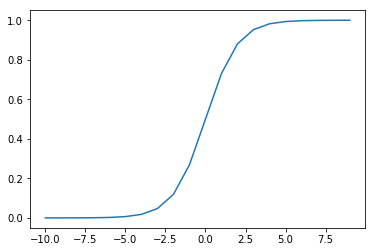

In [12]:
ax = plt.axes()
xs = np.arange(-10,10)
ax.plot(xs, 1 / (1 + np.exp(-xs)))

Como se señaló anteriormente, la función sigmoidea se define como
$$
\mathrm{sigmoid}(a) = \frac{1}{1 + e^{-a}} .
$$
¿Puedes mostrar eso?
$$
1 - \mathrm{sigmoid}(a) = \frac{1}{1 + e^{a}} ,
$$
y dibujar ambos en una hoja de papel?

* ¿Cuál es su valor cuando $a = \mathbf{w}^{T}\mathbf{x}$ es positivo? ¿negativo? y cero?
* ¿Qué sucede con su valor cuando$a = \mathbf{w}^{T}\mathbf{x}$ se hace más grande?
* ¿Cuál es el valor de $\mathrm{sigmoid}(\mathbf{w^Tx})$  cuando $\mathbf{w}^T\mathbf{x} = 0$? ¿Cómo cambia esto cómo clasificamos los puntos a ambos lados del límite de decisión?

** SUGERENCIA **: Recuerda que la idea de la función de pérdida es devolver valores pequeños cuando el clasificador hace buenas predicciones y valores grandes cuando el clasificador hace malas predicciones.

* Si no te siente cómodo con las matemáticas *, recuerde que el objetivo principal de esta pregunta es ** resaltar la importancia de la pérdida binaria de entropía cruzada ** y ** NO ** las matemáticas, ¡así que  a concéntrarse en los conceptos!

**Pregunta extra**

Derivamos la función compute_loss () anterior basada en minimizar la pérdida logarítmica del error de predicción. Esto está relacionado con un concepto llamado 'entropía cruzada'. Pero otra forma de derivar exactamente la misma función de pérdida es maximizando la probabilidad de los datos bajo el modelo $P(y | x, w_1, w_2)$. Si está familiarizado con este concepto (por ejemplo, a partir de estadísticas), vea si también puede derivarlo de esta manera.

###Lectura adicional opcional
Más información  [cross-entropy loss](http://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html) y otra info interesante [information theory](https://rdipietro.github.io/friendly-intro-to-cross-entropy-loss/).


## Loss value for your chosen $w_1$ and $w_2$

La siguiente línea de código calcula el valor de pérdida para los valores elegidos de $w_1$ y $w_2$. Intenta cambiar los valores de $w_1$ y $w_2$ con los controles deslizantes. 

¿Puedes ver cómo una mejor separación resulta en una pérdida menor?

**Nota:** Si has usado una versión anterior de TensorFlow anteriormente, ¡puede ser confuso cómo funciona esta celda de código! 

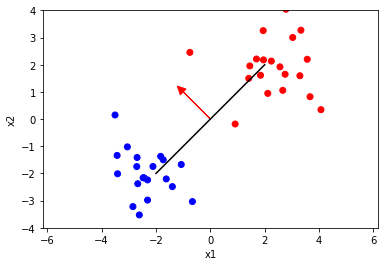

1.0957342554876406

In [14]:
#@title Effect of parameters on the loss {run: "auto"}

# Define the parameters
w1 = -1 #@param { type: "slider", min: -5, max: 5, step: 0.1 }
w2 = 1 #@param { type: "slider", min: -5, max: 5, step: 0.1 }

plot_dataset(inputs, labels)

# Add the weight vector to the plot. We plot it in red, as it has to "point"
# in the direction of the red points.
ax = plt.axes()
ax.arrow(0, 0, w1, w2, head_width=0.3, head_length=0.3, fc='r', ec='r')

# Plot part of the decision boundary in black. It is orthogonal to the weight
# vector.
t = 2 # this is how long the line should be
plt.plot([-t * w2, t * w2], [t * w1, -t * w1], 'k-')

plt.xlim([-4, 4])
plt.ylim([-4, 4])

plt.show()

compute_loss(w1, w2, inputs, labels).numpy()

## Visualising the loss function

Podemos visualizar la función de pérdida para nuestro conjunto de datos trazando su valor en cada punto de una cuadrícula completa de valores de parámetros $w_1$ y $w-2$. Hacemos esto usando un diagrama de contorno, que es una técnica para visualizar una función tridimensional en un diagrama bidimensional dejando que el color represente la tercera dimensión. Todos los puntos con el mismo color tienen el mismo valor de pérdida.

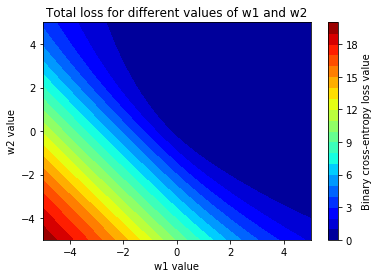

In [15]:
# We define a function so we can re-use this code later
def plot_contours():  
  # Generate a whole bunch of (w1, w2) points in a grid
  ind = np.linspace(-5, 5, 50)
  w1grid, w2grid = np.meshgrid(ind, ind)

  # Compute the loss for each point in the grid
  losses = []
  for w1s, w2s in zip(w1grid, w2grid):
    loss = compute_loss(w1s, w2s, inputs, labels)
    losses.append(loss)

  # Pack the loss values for every value of w1 & w2 into one (50,50) array
  losses_array = np.concatenate(losses).reshape(50,50)

  # Now plot the resulting loss function as a contour plot over the whole grid of (w1, w2) values.
  fig = plt.figure()
  plt.contourf(w1grid, w2grid, losses_array, 20, cmap=plt.cm.jet)
  cbar = plt.colorbar()
  cbar.ax.set_ylabel('Binary cross-entropy loss value')
  plt.xlabel('w1 value')
  plt.ylabel('w2 value')
  plt.title('Total loss for different values of w1 and w2')

plot_contours()

En la barra de la derecha, a medida que el color va de rojo a azul, el valor de pérdida disminuye y disminuye hasta alcanzar el valor más pequeño (azul oscuro).

Dado que queremos que la pérdida sea lo más pequeña posible, queremos que nuestros valores de $w_1$ y $w_2$ produzcan una pérdida en el área azul oscuro de la gráfica de contorno. Esto se logra dentro de un cierto rango de valores para $w_1$ y $w_2$.

Pregunta: ¿Puedes leer qué valores de $w_1$ y $w_2$ te darán la menor pérdida? 

¿Son estos valores similares a los que encontró anteriormente para separar linealmente los datos?

**Pregunta**: Dependiendo del punto central que elijas, el valor más pequeño para la pérdida puede no ser 0. ¿En qué circunstancias es este el caso?

##Optimizando la pérdida usando TensorFlow

Ahora que tenemos una función que nos da la pérdida para diferentes valores de $ w_1 $ y $ w_2 $, queremos un método automatizado para encontrar los valores que minimicen la función de pérdida. Aquí es donde entra en juego la optimización por **descenso de gradiente**. La idea es que para cada (batch of) puntos de datos, calculemos la pérdida utilizando los valores actuales de $ w_1 $ y $ w_2 $ en los datos. Luego calculamos el **gradiente** (o derivado) de la función de pérdida en los valores actuales de $ w_1 $ y $ w_2 $. El negativo del gradiente apunta en la dirección del *steepest descent* a lo largo de la función de pérdida. Al ajustar los valores de $ w_1 $ y $ w_2 $ en la dirección del gradiente negativo, nos acercamos al mínimo de la función de pérdida (siempre que la función de pérdida tenga un "buen comportamiento"). El gran paso que damos está mediado por la **tasa de aprendizaje**. Para hacer esto más fácilmente, usaremos TensorFlow.



##Optional extra reading: TensorFlow

*TensorFlow* (TF) es una biblioteca de software de código abierto para el cálculo numérico que utiliza el concepto de tensores. Puedes pensar en los tensores como una generalización de matrices a dimensiones superiores, o más o menos equivalentes a matrices multidimensionales. Los escalares son tensores de 0 dimensiones, los vectores son de 1 dimensión, las matrices estándar son de 2 dimensiones y los tensores de dimensiones superiores tienen 3 o más dimensiones. Puedes pensar que las dimensiones representan grupos de números que significan lo mismo. Por ejemplo, para las imágenes, a menudo utilizamos tensores tridimensionales donde la primera dimensión representa los canales de color rojo, verde y azul de la imagen, y los dos siguientes son las columnas y filas de píxeles de la imagen.

**Nota:** No te confundas cuando las personas digan "vector 2-D" o "vector 3-D", que se refiere a un tensor unidimensional que tiene tamaño 2 o 3.

La principal ventaja de usar TensorFlow es que puede derivar automáticamente los gradientes de muchas expresiones matemáticas que involucran tensores. Lo logra a través de un proceso llamado "diferenciación automática". Tensorflow también admite múltiples "núcleos", lo que le permite ejecutar fácilmente su código en procesadores normales (CPU), tarjetas gráficas (GPU) y otros aceleradores de hardware más exóticos como las Unidades de procesamiento de tensor (TPU) de Google

Tensorflow en realidad proporciona dos modos de operación, el primero, llamado "modo gráfico", crea un gráfico de cálculo por adelantado y luego introduce datos en el gráfico. Al construir el gráfico por adelantado, Tensorflow puede aplicar optimizaciones al gráfico que le permiten extraer el máximo rendimiento del hardware que está ejecutando. El segundo modo, llamado "Eager-mode", es mucho más nuevo y evalúa las operaciones de Tensor de manera imperativa (en el orden en que las escribe), similar a NumPy y PyTorch. Eager-mode es un poco menos eficiente pero mucho más intuitivo, especialmente si nunca antes ha usado un estilo de programación "definir y ejecutar" (como el modo gráfico). 

### Usando Tensorflow para optimizar la pérdida
Utilizamos TensorFlow para optimizar los parámetros del modelo con descenso de gradiente. Recorremos el conjunto de datos varias veces (llamadas "epochs") y trazamos el límite de decisión final junto con un diagrama que muestra cómo los parámetros y la pérdida cambiaron durante las épocas.

**Nota**: TensorFlow probablemente es excesivo para este ejemplo, porque el gradiente es muy fácil de calcular.

<dtype: 'float64'>
Finished optimisation, the final values of w1 and w2 are:
(2.017177322707697, 1.0905288562693618, <tf.Tensor: id=342058, shape=(), dtype=float64, numpy=0.013681986409541411>)


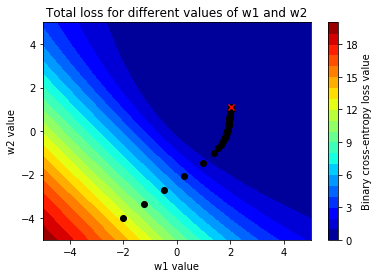

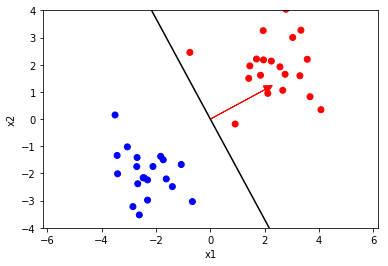

In [16]:
lr = 0.33  # The learning rate

# Initialise Tensorflow variables representing our parameters.
# We need to use TensorFlow variables here rather than Numpy or Python ones so 
# that TensorFlow is able to compute gradients.
w1 = tf.Variable(-2.0, dtype=tf.float64)  
w2 = tf.Variable(-4.0,  dtype=tf.float64)  
print(w1.dtype)

plot_contours()

# Loop over the dataset multiple times
parameter_values = []
for epoch in range(100):
  plt.scatter(w1.numpy(), w2.numpy(), marker='o', color='black')
  
  # The GradientTape is how TF keeps track of gradients in Eager-mode
  with tf.GradientTape() as tape:
    loss = compute_loss(w1, w2, inputs, labels)
  
  # Now we take a step in parameter space in the direction of the gradient to move the parameters closer (hopefully!) to their optimum
  dw1, dw2 = tape.gradient(loss, [w1, w2])
  
  # Step 'lr units' in the direction of the negative gradient
  # We achieve this by subtracting lr * dw1 and lr * dw2 from the w1 and w2 variables
  w1.assign_sub(lr*dw1)
  w2.assign_sub(lr*dw2)
  
print('Finished optimisation, the final values of w1 and w2 are:')
print(w1.numpy(), w2.numpy(), loss)

# Plot the final point on the loss surface.
plt.scatter(w1.numpy(), w2.numpy(), marker='x', color='red')
plt.show()

# Plot the final decision boundary
plot_dataset(inputs, labels)
ax = plt.axes()
ax.arrow(0, 0, w1.numpy(), w2.numpy(), head_width=0.3, head_length=0.3, fc='r', ec='r')
plt.plot([-2 * w2.numpy(), 2 * w2.numpy()], [2 * w1.numpy(), -2 * w1.numpy()], 'k-')

plt.xlim([-4, 4])
plt.ylim([-4, 4])

plt.show()

¿Puedes ver cómo el modelo atraviesa el diagrama de contorno hasta que minimiza la pérdida?

¿Cómo se corresponden los valores finales de $w_1$ y $w_2$ encontrados por Tensorflow con los valores que encontró manualmente? Si no lo son, ¿puedes explicar por qué?

## Tareas opcionales
Si has trabajado en esta práctica, has respondido todas las preguntas y sientes que comprendes bien lo que está sucediendo, intenta las siguientes tareas:

1. Agregue un parámetro **sesgo** a la ecuación para el límite de decisión y visualiza cómo eso cambia el límite de decisión, la pérdida y la solución final encontrada por Tensorflow.
2. Agregue un **regularizador**, por ejemplo, el regularizador L2 (consulta el apéndice a continuación para obtener más información): ¿cómo afecta el diagrama de contorno de los parámetros frente a la pérdida? ¿Cómo afecta la pérdida el cambio en la fuerza de la regularización?


# Appendix

Dos de los métodos de regularización más simples son la regularización L1 y L2 (o mejor conocidos como _Lasso_ y _Ridge_ regresión si has utilizado la regresión lineal antes). Ambos métodos regularizan el modelo agregando un término a la pérdida que penaliza el modelo si se vuelve demasiado complejo.
La regularización L1 agrega un término basado en la norma L1:

$loss_{L1} = loss + \lambda \sum_i |w_i|$

donde $\lambda$ es un parámetro que controla la cantidad de regularización, y $w_i$ son los parámetros del modelo. La regularización de L1 tiene el efecto de obligar a algunos parámetros a reducirse a 0, eliminándolos efectivamente del modelo.

La regularización L2 agrega de manera similar un término basado en la norma L2:

$loss_{L2} = loss + \lambda \sum_i w_i^2$.

La regularización de L2 tiene el efecto de evitar que cualquiera de los parámetros se vuelva demasiado grande y sobrecargar a los demás.

En algunos casos, puede funcionar bien usar tanto la regularización L1 como la L2.

Para obtener más información, (http://enhancedatascience.com/2017/07/04/machine-learning-explained-regularization/) y  (https://towardsdatascience.com/l1-and- l2-regularization-method-ce25e7fc831c).